In [44]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()


Fully Connected Layer (Layer_Dense)
This class implements a dense layer, also known as a fully connected layer.

 __init__: Layer Initialization
Initializes:

Weights: small random numbers scaled by 0.01 (to break symmetry).

Biases: initialized to zeros.

Stores L1 and L2 regularization strength for both weights and biases.

 forward(): Forward Pass
Computes the output using:

output
=
𝑋
⋅
𝑊
+
𝑏
output=X⋅W+b
Saves inputs for use in backpropagation.

 backward(): Backward Pass
Calculates gradients:

dweights, dbiases: gradients of loss w.r.t. weights/biases.

Adds L1 and L2 regularization terms if applicable.

dinputs: gradient to pass to the previous layer.

In [45]:
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
        # Store regularization strengths
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs  # Save input values for use in backward pass
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on weights and biases
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Regularization - L1 and L2 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        # Regularization - L1 and L2 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        # Gradient on inputs (for previous layer)
        self.dinputs = np.dot(dvalues, self.weights.T)




Dropout Regularization (Layer_Dropout)
Dropout is a regularization technique used to prevent overfitting.

During training:

A random subset of neurons is "dropped" (set to 0).

This forces the network to not depend too heavily on any one neuron.

At inference time, dropout is not used.

 forward():
Creates a binary mask (0s and 1s) using a binomial distribution.

Applies this mask to the input, scaling the remaining values to maintain output magnitude.

backward():
Applies the same binary mask to the gradient coming from the next layer to block the flow of gradients through dropped neurons.

In [46]:
# Dropout
class Layer_Dropout:
    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                                              size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask

    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask


.

 SECTION 4: ReLU Activation Function
 Markdown Cell (Explanation):
 Activation Function: ReLU (Rectified Linear Unit)
ReLU is a non-linear activation function used in hidden layers.
It allows the network to learn complex relationships while avoiding vanishing gradients.

 forward():
Applies the function:

ReLU
(
𝑥
)
=
max
⁡
(
0
,
𝑥
)
ReLU(x)=max(0,x)
Any negative values are set to 0; positive values remain unchanged.

backward():
During backpropagation, gradients are allowed to pass through only where the input was positive.

If the input was ≤ 0, the gradient is set to 0.

In [47]:
# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


 Activation Function: Softmax
Softmax is used in the output layer for multi-class classification.
It converts raw scores (logits) into normalized probabilities that sum to 1.

forward():
Computes exponentials of inputs (after stabilizing by subtracting max).

Normalizes them so that for each sample, the output vector sums to 1.

backward():
The derivative of softmax is more complex — it requires a Jacobian matrix.

For each sample, we compute:

𝐽=
diag
(
𝑠
)
−
𝑠
⋅
𝑠
𝑇
J=diag(s)−s⋅s 
T
 
where 
𝑠
s is the softmax output vector.

This matrix is then multiplied by the incoming gradient.

In [48]:
# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)
        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):

            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - \
                np.dot(single_output, single_output.T)

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


###  Activation Function: Sigmoid

The **sigmoid** activation function is used in the **output layer** for **binary classification** problems.  
It transforms input values into probabilities between 0 and 1.

#### Formula:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

---

###  Forward Pass:
Applies the sigmoid function element-wise to each input:
- For large positive input: output approaches 1
- For large negative input: output approaches 0

The output is stored for use during backpropagation.

---

###  Backward Pass:
To propagate gradients backward, we use the derivative of sigmoid:

$$
\sigma'(x) = \sigma(x)(1 - \sigma(x))
$$

The gradient of the loss with respect to the inputs is:

$$
\text{dinputs} = \text{dvalues} \cdot \sigma(x)(1 - \sigma(x))
$$

This controls how much each input contributed to the loss.


In [49]:
# Sigmoid activation
class Activation_Sigmoid:
    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output


###  Optimizer: Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent (SGD) is the most basic optimizer used in training neural networks.  
It updates weights and biases by moving in the direction **opposite** to the gradient of the loss function.

---

###  Update Rule (Vanilla SGD):
$$
\theta = \theta - \alpha \cdot \nabla_\theta L
$$
Where:
- \( \theta \): parameters (weights/biases)
- \( \alpha \): learning rate
- \( \nabla_\theta L \): gradient of the loss with respect to \( \theta \)

---

###  Optional Extensions:
- **Learning rate decay**: Reduces learning rate over time:
$$
\alpha_t = \frac{\alpha_0}{1 + \text{decay} \cdot t}
$$

- **Momentum**: Accelerates convergence by using an exponentially decaying moving average of past gradients:
$$
v_t = \beta v_{t-1} - \alpha \nabla_\theta L \\
\theta = \theta + v_t
$$

---

###  Method Summary:
- `pre_update_params()`: Adjusts learning rate using decay.
- `update_params(layer)`: Applies gradient updates with/without momentum.
- `post_update_params()`: Increments the iteration count.


In [50]:
# SGD optimizer
class Optimizer_SGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If we use momentum
        if self.momentum:
            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


###  Optimizer: Adagrad

**Adagrad** is an adaptive learning rate optimizer.  
It adapts the learning rate for each parameter individually based on how frequently it's updated.

---

###  Key Concept:
- Parameters with **frequent updates** receive **smaller learning rates**.
- Parameters with **infrequent updates** get **larger learning rates**.
- It uses an accumulator (cache) of squared gradients.

---

###  Update Rule:
For each parameter \( \theta \):
$$
G_t = G_{t-1} + \nabla_\theta^2 L \\
\theta = \theta - \frac{\alpha}{\sqrt{G_t} + \epsilon} \cdot \nabla_\theta L
$$

Where:
- \( G_t \): sum of squared gradients
- \( \epsilon \): small number to avoid division by zero

---

###  Method Summary:
- `pre_update_params()`: Applies learning rate decay.
- `update_params(layer)`: Uses cached squared gradients to scale the learning rate.
- `post_update_params()`: Increments iteration count.


In [51]:
# Adagrad optimizer
class Optimizer_Adagrad:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
            layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
            layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


### Optimizer: RMSprop (Root Mean Square Propagation)

**RMSprop** is an adaptive learning rate optimizer, like Adagrad, but it uses an **exponentially decaying average** of past squared gradients instead of summing them.  
This prevents the learning rate from shrinking too much over time.

---

###  Key Concept:
Instead of accumulating all squared gradients, RMSprop maintains a **moving average**:

$$
E[g^2]_t = \rho \cdot E[g^2]_{t-1} + (1 - \rho) \cdot g_t^2 \\
\theta = \theta - \frac{\alpha}{\sqrt{E[g^2]_t} + \epsilon} \cdot g_t
$$

Where:
- \( \rho \): decay rate (typically 0.9)
- \( \epsilon \): small constant to prevent division by zero

---

###  Method Summary:
- `pre_update_params()`: Handles learning rate decay.
- `update_params(layer)`: Updates weights using RMS of recent gradients.
- `post_update_params()`: Increments the iteration counter.


In [52]:
# RMSprop optimizer
class Optimizer_RMSprop:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Parameter update with normalization
        layer.weights += -self.current_learning_rate * \
            layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
            layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


###  Optimizer: Adam (Adaptive Moment Estimation)

**Adam** combines the advantages of:
- **Momentum** (uses moving averages of gradients)
- **RMSprop** (uses moving averages of squared gradients)

Adam is widely used for training deep neural networks because it works well **out of the box** with little tuning.

---

###  Key Concepts:

- **Momentum estimate** (first moment):
$$
m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t
$$

- **RMS estimate** (second moment):
$$
v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2
$$

- **Bias correction**:
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

- **Parameter update**:
$$
\theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

---

###  Method Summary:
- `pre_update_params()`: Adjusts learning rate with decay.
- `update_params(layer)`: Applies moment + RMS scaling + correction.
- `post_update_params()`: Increments iteration count.


In [53]:
# Adam optimizer
class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + \
            (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + \
            (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
            weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
            bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


###  Base Class: Loss

The `Loss` class serves as a **base** for all loss functions. It provides:

- A method to compute **regularization loss** using L1 and L2 penalties.
- A `calculate()` method that:
  1. Calls the child class's `forward()` to compute sample-wise loss.
  2. Averages it to compute the batch loss.

---

###  Regularization Loss Formula:

- L1 Regularization:
$$
L_{1} = \lambda \sum |w|
$$

- L2 Regularization:
$$
L_{2} = \lambda \sum w^2
$$

These are added to the main data loss to compute total loss.


In [54]:
# Common loss class
class Loss:
    # Regularization loss calculation
    def regularization_loss(self, layer):
        # 0 by default
        regularization_loss = 0

        # L1 regularization - weights
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * \
                np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * \
                np.sum(layer.weights * layer.weights)

        # L1 regularization - biases
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * \
                np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * \
                np.sum(layer.biases * layer.biases)

        return regularization_loss

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss


###  Loss: Categorical Cross-Entropy

**Categorical Cross-Entropy** is used when the model outputs a **probability distribution** over multiple classes.

---

###  Forward Pass:

Given predicted probabilities \( \hat{y} \) and true labels \( y \), the loss for a sample is:

$$
L = -\log(\hat{y}_{\text{true class}})
$$

- If labels are **sparse**: use `y_true` as indices.
- If labels are **one-hot encoded**: use element-wise multiplication and sum.

We clip \( \hat{y} \) to avoid log(0) and numerical instability.

---

###  Backward Pass:

The gradient of the loss w.r.t. the predictions is:

$$
\frac{\partial L}{\partial \hat{y}} = -\frac{y_{\text{true}}}{\hat{y}}
$$

Gradients are normalized by dividing by number of samples.


In [55]:
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values - only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


###  Combined Softmax Activation and Categorical Cross-Entropy Loss

This class combines two operations:
1. **Softmax activation** (turns logits into probabilities)
2. **Categorical cross-entropy loss** (computes log loss from probabilities)

---

###  Why Combine?

When computed separately, softmax and cross-entropy can become **numerically unstable**.  
This class computes their derivative directly, **bypassing the need to compute a full Jacobian matrix**, and simplifies the backward pass to:

$$
\text{dinputs} = \hat{y} - y
$$

Where:
- \( \hat{y} \): predicted probabilities
- \( y \): one-hot encoded or sparse true labels

---

###  Method Summary:
- `forward(inputs, y_true)`: Applies softmax + computes cross-entropy.
- `backward(dvalues, y_true)`: Computes simplified gradient in one step.


In [56]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded, turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


###  Loss: Binary Cross-Entropy

This loss is used when the model performs **binary classification**, i.e., predicting a value between 0 and 1 using the **sigmoid activation** in the output layer.

---

###  Forward Pass:

The binary cross-entropy loss for predicted probability \( \hat{y} \) and true label \( y \in \{0, 1\} \) is:

$$
L = -\left[ y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right]
$$

- The output \( \hat{y} \) is **clipped** between \( 1 \times 10^{-7} \) and \( 1 - 10^{-7} \) to avoid log(0).
- The average over all output neurons (axis = -1) is computed.

---

###  Backward Pass:

The gradient of binary cross-entropy w.r.t. predictions:

$$
\frac{\partial L}{\partial \hat{y}} = -\left[ \frac{y}{\hat{y}} - \frac{1 - y}{1 - \hat{y}} \right]
$$

Then normalize by dividing over:
- number of **outputs** per sample
- number of **samples**

This provides the gradient to pass back to the previous layer.


In [57]:
# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs

        # Normalize gradient
        self.dinputs = self.dinputs / samples


###  Full Neural Network Training (Binary Classification)

Now we use everything we've built:

- A two-layer neural network:
  - Dense → ReLU → Dense → Sigmoid
- Binary cross-entropy loss
- Adam optimizer with learning rate decay
- Regularization to reduce overfitting

We use a **spiral dataset** with 2 classes and 2D inputs.

---

###  Network Summary:

- **Layer 1**:
  - Input: 2 features
  - Output: 64 neurons
  - Activation: ReLU
  - L2 regularization

- **Layer 2**:
  - Input: 64 features
  - Output: 1 neuron
  - Activation: Sigmoid

- **Loss**: Binary cross-entropy

- **Optimizer**: Adam (adaptive learning + momentum)

---

###  Training Loop:

1. Forward pass → through all layers + activations
2. Compute loss:
   - Data loss + L2 regularization penalty
3. Compute accuracy:
   - Use threshold: \( \hat{y} > 0.5 \rightarrow 1 \)
4. Backward pass → gradients for all layers
5. Optimizer updates weights
6. Repeat for many epochs (10,000+)

---

###  Evaluation:
At the end, we evaluate the model using **unseen test data**.


In [58]:
loss_history = []
accuracy_history = []


In [59]:
# Create dataset
X, y = spiral_data(samples=100, classes=2)
y = y.reshape(-1, 1)  # Reshape to column vector

# Create layers
dense1 = Layer_Dense(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 1)
activation2 = Activation_Sigmoid()

# Create loss and optimizer
loss_function = Loss_BinaryCrossentropy()
optimizer = Optimizer_Adam(decay=5e-7)

# Training loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # Compute loss
    data_loss = loss_function.calculate(activation2.output, y)
    reg_loss = loss_function.regularization_loss(dense1) + \
               loss_function.regularization_loss(dense2)
    loss = data_loss + reg_loss

    # Accuracy
    predictions = (activation2.output > 0.5) * 1
    accuracy = np.mean(predictions == y)

    # Log progress
    loss_history.append(loss)
    accuracy_history.append(accuracy)


    if not epoch % 100:
        print(f'epoch: {epoch}, acc: {accuracy:.3f}, loss: {loss:.3f} '
              f'(data: {data_loss:.3f}, reg: {reg_loss:.3f}), '
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update parameters
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

# Validation
X_test, y_test = spiral_data(samples=100, classes=2)
y_test = y_test.reshape(-1, 1)

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)

loss = loss_function.calculate(activation2.output, y_test)
predictions = (activation2.output > 0.5) * 1
accuracy = np.mean(predictions == y_test)

print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')


epoch: 0, acc: 0.500, loss: 0.693 (data: 0.693, reg: 0.000), lr: 0.001
epoch: 100, acc: 0.630, loss: 0.674 (data: 0.673, reg: 0.001), lr: 0.0009999505024501287
epoch: 200, acc: 0.625, loss: 0.669 (data: 0.668, reg: 0.001), lr: 0.0009999005098992651
epoch: 300, acc: 0.645, loss: 0.665 (data: 0.663, reg: 0.002), lr: 0.000999850522346909
epoch: 400, acc: 0.650, loss: 0.659 (data: 0.657, reg: 0.002), lr: 0.0009998005397923115
epoch: 500, acc: 0.675, loss: 0.648 (data: 0.644, reg: 0.004), lr: 0.0009997505622347225
epoch: 600, acc: 0.720, loss: 0.632 (data: 0.626, reg: 0.006), lr: 0.0009997005896733929
epoch: 700, acc: 0.770, loss: 0.614 (data: 0.604, reg: 0.010), lr: 0.0009996506221075735
epoch: 800, acc: 0.775, loss: 0.594 (data: 0.579, reg: 0.015), lr: 0.000999600659536515
epoch: 900, acc: 0.775, loss: 0.575 (data: 0.556, reg: 0.020), lr: 0.0009995507019594694
epoch: 1000, acc: 0.785, loss: 0.560 (data: 0.536, reg: 0.024), lr: 0.000999500749375687
epoch: 1100, acc: 0.790, loss: 0.547 (dat

Matplotlib is building the font cache; this may take a moment.


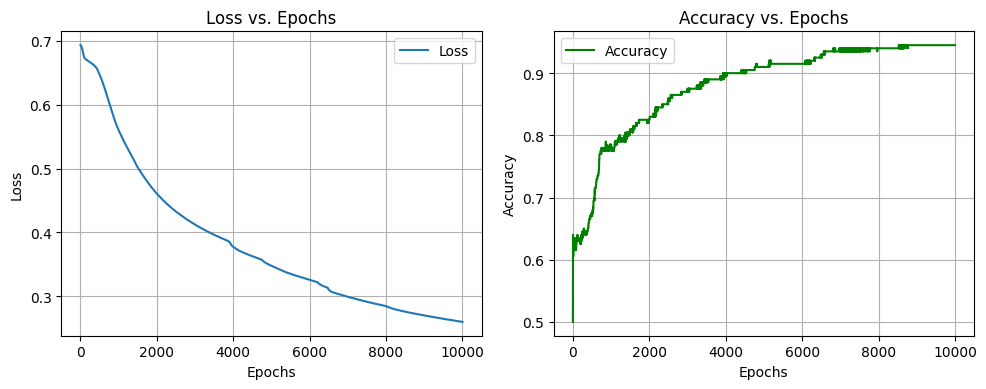

In [61]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy', color='green')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
